# Probability of success transmission of LoRa messages

For given period of time (*n* seconds) return probability of successful transimission of LoRa uplink message. 

Probability should rise up as time period gets bigger (*n*  is bigger). 
$$ n = 0 \Rightarrow p_{st} = 0 $$ 

$$ n \in <0, +\infty> \Rightarrow p_{st} \in <0, 1> $$

$$ n = \infty \Rightarrow p_{st} = 1 $$

Estimation of successfully transmitted messages will be inferenced from LSTM output but function evaluation will be performed on measured data from real deployment. Data is structured as time series sequence of 1s and 0s which represents device activity. Resolution of time is on scale of seconds. Since the data is measured for the long period of time (more than few months), only partial data will be considered.

In [1]:
import pandas as pd
import os

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
PROCESSED_PATH = 'data/processed'

df = pd.read_csv(os.path.join(PROJ_ROOT, PROCESSED_PATH, 'single_device_activation.csv'),
                header=0, sep=',')

Function will take 3 parameters:
- data - original dataset structured as described above
- sample - if the partial data taken as argument above is considered as population this will be finite sample of the population
- window - number that represents number of elements of sliding window which will go through all of the sampled datam

In [2]:
df[:2000000].Active.value_counts()

0.0    1981627
1.0      18373
Name: Active, dtype: int64

In [9]:
data_test = df[:5000000].copy()

In [5]:
import matplotlib.pyplot as plt
from itertools import islice
import numpy as np

def sampling(data, sample_size):
    """Returns sampled data sets"""
    return [data[x:x+sample_size] for x in range(0, len(data), sample_size)] 

def gen_window(seq, n):
    """Returns a sliding window (of width n) over data from the iterable"""
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def estimate_prob(data, window_size):
    """Returns a probability estimate for given data sample in 
       n=window_size number of seconds"""
    windows = gen_window(data, n=window_size)

    window_prob = []

    for window in windows:
        ones_freq = 0
        for data_point in window:
            if data_point == 1:
                ones_freq += 1
        window_prob.append(ones_freq/window_size)
    return 1 - window_prob.count(0.0)/len(window_prob)

def plot_data(data, time=range(24)):
    fig = plt.figure(facecolor='white', figsize=(12,3))
    plt.plot(time, data, 'b-.o')
    plt.show()

def plot_prob(probs, time_points):
    fig = plt.figure(facecolor='white', figsize=(12,3))
    
    plt.ylabel('est_prob')
    plt.xlabel('time [s]')
    plt.title('Estimated probability of successful transmission of messages')
    
    plt.xscale('log')
    
    plt.plot(time_points, probs)
    
    for a,b in zip(time_points, probs): 
        plt.text(a, round(b, 4), str(round(b, 4)))
    plt.show()

In [10]:
samples = sampling(data_test, sample_size=50000)

In [11]:
probs_acc = {}
max_w_size = [1, 10, 30, 60, 600, 1800, 3600, 9000, 50000]
for idx, sample in enumerate(samples):
    probs = []
    for w in max_w_size:
        probs.append(estimate_prob(sample.Active, window_size=w))
    probs_acc[idx]=probs

In [12]:
p_tot = []
for i in range(len(max_w_size)):
    _s = 0
    for j in range(len(probs_acc)):
        _s += probs_acc[j][i]
    p_tot.append(_s/len(probs_acc))
p_tot

[0.012611599999999994,
 0.12146406353143561,
 0.33341758219767476,
 0.5663937446186499,
 0.8361069613975425,
 0.840757453164872,
 0.8444983944311545,
 0.85197629326114,
 0.9]

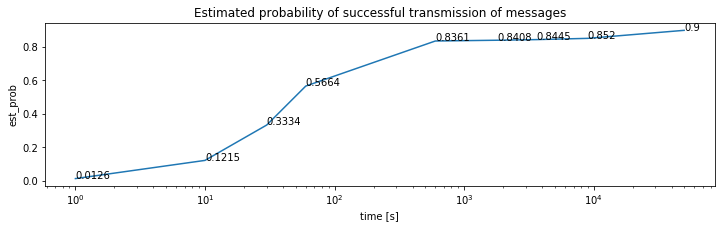

In [13]:
plot_prob(p_tot, max_w_size)

# Evaluation on LSTM predictions

Applying the same procedure to the predicted future values of LSTM network output, we should get *estimation* of probability of successful transmission of LoRa messages from end device to base station.

First lets generate and interpret LSTM output appropriately:

In [14]:
from keras.models import load_model
model = load_model('../saved_models/01052019-092342-e1.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [15]:
import pandas as pd
import numpy as np
import os

def timeDelay(df, delay):
    X_data, y_data = [], []
    
    for i in range(delay, len(df)):
        X_data.append(df[i-delay: i].tolist())
    X_data = np.array(X_data)
    y_data = df[delay:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)),\
           np.reshape(y_data, (len(y_data), ))

def split(X, y, ratio):    
    test_split = int(len(X) * ratio)
    
    X_train, y_train = X[:test_split], y[:test_split]
    X_test, y_test = X[test_split:], y[test_split:]
    return X_train, y_train, X_test, y_test

# train-test split on processed dataset
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
PROCESSED_PATH = 'data/processed'

df = pd.read_csv(os.path.join(PROJ_ROOT, PROCESSED_PATH, 'single_device_activation.csv'),
                header=0, sep=',')

X, y = timeDelay(df.Active.values, delay=5)
X_train, y_train, X_test, y_test = split(X, y, ratio=0.8)

In [16]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [17]:
unique, counts = np.unique(y_test, return_counts=True)

np.asarray((unique, counts)).T

array([[0.000000e+00, 5.824563e+06],
       [1.000000e+00, 2.100000e+01]])

In [18]:
y_test_pred = np.reshape(y_test_pred, (y_test_pred.size,))
y_test_pred

array([2.8398631e-06, 2.8398631e-06, 2.8398631e-06, ..., 2.8398631e-06,
       2.8398633e-06, 2.8398633e-06], dtype=float32)

In [19]:
unique, counts = np.unique(y_test_pred, return_counts=True)

np.asarray((unique, counts)).T

array([[2.83986310e-06, 5.46045200e+06],
       [2.83986333e-06, 3.64032000e+05],
       [5.11100006e-06, 2.00000000e+01],
       [5.55253200e-06, 3.00000000e+00],
       [5.55253246e-06, 1.70000000e+01],
       [6.64733943e-06, 1.70000000e+01],
       [6.64734080e-06, 3.00000000e+00],
       [8.57259147e-06, 2.00000000e+01],
       [9.02727152e-06, 2.00000000e+01]])

In [20]:
y_test_pred[y_test_pred==2.83986310e-06]=0
y_test_pred[y_test_pred==2.83986333e-06]=0
y_test_pred[y_test_pred!=0]=1
y_test_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

Now, same thing should be done for *y_test_pred* array as it had been done previously for actual measured data in deployment.
*y_test_pred* is filled with 1s and 0s which represents predicted device activity for the future time points (second-precision).

In [23]:
print('y_test_pred number of data points:', len(y_test_pred))

y_test_pred number of data points: 5824584


In [31]:
predicted_data = pd.DataFrame({'Active':list(y_test_pred)})

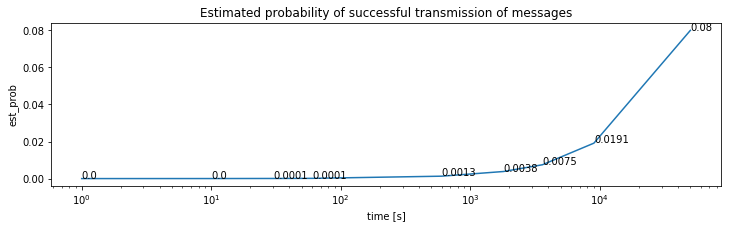

In [38]:
samples = sampling(predicted_data[:5000000], sample_size=50000)

probs_acc = {}
max_w_size = [1, 10, 30, 60, 600, 1800, 3600, 9000, 50000]
for idx, sample in enumerate(samples):
    probs = []
    for w in max_w_size:
        probs.append(estimate_prob(sample.Active, window_size=w))
    probs_acc[idx]=probs

p_tot = []
for i in range(len(max_w_size)):
    _s = 0
    for j in range(len(probs_acc)):
        _s += probs_acc[j][i]
    p_tot.append(_s/len(probs_acc))
    
plot_prob(p_tot, max_w_size)

# Probability distribution for the same element of the original data

In [17]:
data_test = df[-5824584:].copy()

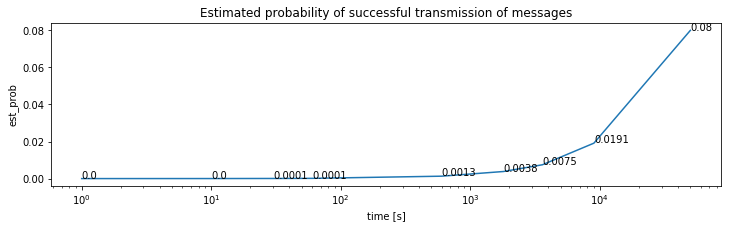

In [18]:
samples = sampling(data_test[:5000000], sample_size=50000)

probs_acc = {}
max_w_size = [1, 10, 30, 60, 600, 1800, 3600, 9000, 50000]
for idx, sample in enumerate(samples):
    probs = []
    for w in max_w_size:
        probs.append(estimate_prob(sample.Active, window_size=w))
    probs_acc[idx]=probs

p_tot = []
for i in range(len(max_w_size)):
    _s = 0
    for j in range(len(probs_acc)):
        _s += probs_acc[j][i]
    p_tot.append(_s/len(probs_acc))
    
plot_prob(p_tot, max_w_size)